In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint, wrapper
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

In [2]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/products/Hot_cmems.zarr"
path_to_npp = "../../../1_data_processing/1_1_Forcing/products/Hot_observed_npp_climato.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/products/Hot_climato_obs_zoo.zarr"
export_file_name = "SeapoPym_HOT_climato_obs_npp_opti_all_parameters_2_groups"

In [3]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-01"
TIME_END = "2010-01-01"

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 322kB
Dimensions:              (latitude: 1, longitude: 1, time: 1827, depth: 3)
Coordinates:
  * depth                (depth) int64 24B 0 1 2
  * latitude             (latitude) float64 8B 22.75
  * longitude            (longitude) int64 8B -158
  * time                 (time) datetime64[ns] 15kB 2005-01-01 ... 2010-01-01
Data variables: (12/13)
    T                    (latitude, longitude, time, depth) float64 44kB 24.7...
    U                    (latitude, longitude, time, depth) float64 44kB -0.0...
    V                    (latitude, longitude, time, depth) float64 44kB 0.15...
    mnkc_epi             (latitude, longitude, time) float64 15kB 0.2904 ... ...
    mnkc_hmlmeso         (latitude, longitude, time) float64 15kB 0.8233 ... ...
    mnkc_lmeso           (latitude, longitude, time) float64 15kB 2.403 ... 1...
    ...                   ...
    mnkc_mumeso          (latitude, longitude, time) float64 15kB 0.5779 ... ...
    mnkc_umeso           (latitude, longitude, time) float64 15kB 0.79 ... 0....
    npp                  (latitude, longitude, time) float64 15kB 221.1 ... 3...
    pelagic_layer_depth  (latitude, longitude, time, depth) float64 44kB 107....
    zeu                  (latitude, longitude, time) float64 15kB 71.63 ... 7...
    zooc                 (latitude, longitude, time) float64 15kB 0.2527 ... ...
Attributes:
    Conventions:  CF-1.7
    history:      Created on 2024-10-17
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    source:       SEAPODYM-LMTL 3.0.0
    title:        Global ocean low and mid trophic levels biomass content hin...

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[107.43817318960242 107.62027138586784 111.3608022247511 ... 122.58406536705469 117.0609769555549 112.42833201753643]]]
Units,meter


<!-- ## Observed NPP -->


In [6]:
# cafe_npp = xr.open_dataset(path_to_cafe, engine="zarr")
# cafe_npp = cafe_npp.sel(time=slice(TIME_START, TIME_END))
# cafe_npp = cafe_npp.dropna("time", how="all")
# cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
# cafe_npp.time.attrs["axis"] = "T"
# cafe_npp.load()

observed_npp = xr.open_zarr(path_to_npp)
observed_npp = observed_npp.sel(time=slice(TIME_START, TIME_END))
observed_npp = observed_npp.dropna("time", how="all")
observed_npp = observed_npp.resample(time="D").interpolate("linear")
observed_npp.load()

<xarray.Dataset> Size: 44kB
Dimensions:          (time: 1821, latitude: 1, longitude: 1)
Coordinates:
  * latitude         (latitude) float64 8B 22.75
  * longitude        (longitude) int64 8B -158
  * time             (time) datetime64[ns] 15kB 2005-01-02 ... 2009-12-27
Data variables:
    l12              (time, latitude, longitude) float64 15kB 255.4 ... 257.5
    l12_lowess_0.05  (time, latitude, longitude) float64 15kB 259.5 ... 258.8
Attributes:
    desc:     L12 multiplied by ZEU (from CMEMS).
    type:     climatology

### Observations


In [7]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("depth")
observations

<xarray.Dataset> Size: 18kB
Dimensions:            (layer: 1, time: 255, latitude: 1, longitude: 1)
Coordinates:
  * layer              (layer) int64 8B 0
  * time               (time) datetime64[ns] 2kB 2005-01-16 ... 2009-12-27
  * latitude           (latitude) float64 8B 22.75
  * longitude          (longitude) int64 8B -158
Data variables:
    day                (time, layer, latitude, longitude) float64 2kB [mg/m²] ...
    day_lowess_0.05    (time, layer, latitude, longitude) float64 2kB [mg/m²] ...
    day_lowess_0.1     (time, layer, latitude, longitude) float64 2kB [mg/m²] ...
    day_lowess_0.2     (time, layer, latitude, longitude) float64 2kB [mg/m²] ...
    night              (time, layer, latitude, longitude) float64 2kB [mg/m²] ...
    night_lowess_0.05  (time, layer, latitude, longitude) float64 2kB [mg/m²] ...
    night_lowess_0.1   (time, layer, latitude, longitude) float64 2kB [mg/m²] ...
    night_lowess_0.2   (time, layer, latitude, longitude) float64 2kB [mg/m²] ...

Select the kind of observation you want to use.


In [8]:
observations_selected = observations[["day_lowess_0.2","night_lowess_0.2"]].rename({"day_lowess_0.2":"day", "night_lowess_0.2":"night"})

Create structure for SeapoPym simulation.


In [9]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=observed_npp["l12"], resolution=1 / 12, timestep=1),
)

2025-01-21 15:48:25,768 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [10]:
# functional_groups = [
#     FunctionalGroupOptimizeNoTransport(
#         name="D1N1",
#         day_layer=0,
#         night_layer=0,
#         energy_coefficient=Parameter("D1N1_energy_coefficient", 0.001, 0.4),
#         tr_rate=Parameter("D1N1_tr_rate", -0.3, -0.001),
#         tr_max=Parameter("D1N1_tr_max", 0, 50),
#         inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", -0.3, -0.001),
#         inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 500),
#     ),
#     FunctionalGroupOptimizeNoTransport(
#         name="D2N1",
#         day_layer=1,
#         night_layer=0,
#         energy_coefficient=Parameter("D2N1_energy_coefficient", 0.001, 0.4),
#         tr_rate=Parameter("D2N1_tr_rate", -0.3, -0.001),
#         tr_max=Parameter("D2N1_tr_max", 0, 50),
#         inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", -0.3,-0.001),
#         inv_lambda_max=Parameter("D2N1_inv_lambda_max", 0, 500),
#     ),
# ]
# # [1, 1, 0.1668, 10.38, -0.11, 150, 0.15]

In [11]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("Global_tr_rate", -0.3, -0.001),
        tr_max=Parameter("Global_tr_max", 0, 50),
        inv_lambda_rate=Parameter("Global_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("Global_inv_lambda_max", 0, 500),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=1,
        night_layer=0,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("Global_tr_rate", -0.3, -0.001),
        tr_max=Parameter("Global_tr_max", 0, 50),
        inv_lambda_rate=Parameter("Global_inv_lambda_rate", -0.3,-0.001),
        inv_lambda_max=Parameter("Global_inv_lambda_max", 0, 500),
    ),
]

In [12]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[Observation(observations_selected)],
)

Set the genetic algorithm meta parameters.


In [14]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.1,
    ETA=5,
    CXPB=0.8,
    NGEN=10,
    POP_SIZE=500,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [15]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [16]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

And watch the magic on the Dask dashboard :


In [17]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55081,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:55094,Total threads: 3
Dashboard: http://127.0.0.1:55099/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:55084,


## Run the optimization


In [18]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,178.841469,591.538022,0.005802,5239.350558,500,0.000
1,2.459450,12.753454,0.005057,200.339312,500,0.194
2,0.743802,9.639461,0.004898,201.510906,500,0.178
3,0.698501,12.137077,0.003851,270.305231,500,0.204
4,0.153413,1.139213,0.003598,22.038069,500,0.140
5,0.182167,1.672917,0.002919,28.505758,500,0.156
6,0.052700,0.200845,0.002919,2.766051,500,0.166
7,0.130203,2.024895,0.002919,45.198929,500,0.194
8,0.041462,0.137788,0.003239,1.825273,500,0.204


Generations: 100%|██████████| 10/10 [04:38<00:00, 27.82s/it]


## Plot the results


In [19]:
viewer.stats

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,178.841469,591.538022,0.005802,5239.350558,500,0.000
1,2.459450,12.753454,0.005057,200.339312,500,0.194
2,0.743802,9.639461,0.004898,201.510906,500,0.178
3,0.698501,12.137077,0.003851,270.305231,500,0.204
4,0.153413,1.139213,0.003598,22.038069,500,0.140
5,0.182167,1.672917,0.002919,28.505758,500,0.156
6,0.052700,0.200845,0.002919,2.766051,500,0.166
7,0.130203,2.024895,0.002919,45.198929,500,0.194
8,0.041462,0.137788,0.003239,1.825273,500,0.204


In [20]:
viewer.hall_of_fame

D1N1_energy_coefficient  Global_tr_max  Global_tr_rate  \
generation individual                                                           
9          414                        0.391247      22.278644       -0.226878   
5          414                        0.364218      15.078910       -0.004230   
9          174                        0.384960      15.078910       -0.004230   
           291                        0.345864      15.690631       -0.006488   
8          168                        0.392435      15.446736       -0.006488   
...                                        ...            ...             ...   
0          292                        0.303280      26.258961       -0.195875   
           334                        0.385842      40.617538       -0.228930   
           398                        0.394615      49.828382       -0.297728   
           36                         0.184754       6.531438       -0.024498   
           441                        0.300770      26.265511       -0.234720   

                       Global_inv_lambda_max  Global_inv_lambda_rate  \
generation individual                                                  
9          414                     29.952473               -0.145344   
5          414                    166.271694               -0.209587   
9          174                     29.952473               -0.145344   
           291                     29.952473               -0.145344   
8          168                     32.421034               -0.157728   
...                                      ...                     ...   
0          292                    451.337378               -0.023605   
           334                    352.540819               -0.012758   
           398                    486.256057               -0.021962   
           36                     467.207574               -0.005328   
           441                    477.960582               -0.016023   

                       D2N1_energy_coefficient      fitness  
generation individual                                        
9          414                        0.177983     0.002539  
5          414                        0.111194     0.002919  
9          174                        0.212546     0.002946  
           291                        0.212546     0.003203  
8          168                        0.252939     0.003239  
...                                        ...          ...  
0          292                        0.325860  3446.151045  
           334                        0.260407  3907.487207  
           398                        0.190879  4124.436405  
           36                         0.365448  4873.856220  
           441                        0.345010  5239.350558  

[4172 rows x 7 columns]

In [21]:
viewer.fitness_evolution()

In [22]:
viewer.box_plot(3, nbest=1000)

In [34]:
viewer.parallel_coordinates(1000, unselected_opacity=0)

# Generate plots at each station


In [24]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {list(best_individual[0])}")
print(f"Best individual: {list(best_individual[1])}")

Best individual: [0.0, 0.0, 0.3912468895052878, 22.278643946110062, -0.2268778465189612, 29.952472784470608, -0.14534419814382482]
Best individual: [1.0, 0.0, 0.17798262686297833, 22.278643946110062, -0.2268778465189612, 29.952472784470608, -0.14534419814382482]


## Run simulation


In [25]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=best_individual, groups_name=["D1N1", "D2N1"]),
)

model_print.run()

## Plot


### Taylor Diagram


Convert to pandas series.


In [26]:
biomass_pandas = (
    model_print.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
observations_day_pandas = (
    observations.pint.dequantify().day.dropna("time").to_dataframe().reset_index().set_index("time")["day"]
)
observations_night_pandas = (
    observations.pint.dequantify().night.dropna("time").to_dataframe().reset_index().set_index("time")["night"]
)
layer_pandas = epi_layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

In [27]:
biomass_pandas

functional_group,0,1
time,,
2005-01-01,0.000000,0.000000
2005-01-02,99.906774,45.448719
2005-01-03,129.873382,67.648229
2005-01-04,139.592007,79.015133
2005-01-05,142.872980,84.559523
...,...,...
2009-12-28,61.633243,53.779777
2009-12-29,23.632844,29.766015
2009-12-30,9.161591,16.915644


Then resample to month.


In [28]:
monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred_d1n1 = biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d1n1.index = monthly_pred_d1n1.index.to_period("M").to_timestamp()

monthly_pred_d2n1 = biomass_pandas.iloc[:, 1].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d2n1.index = monthly_pred_d2n1.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

In [29]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass during day (CAFE npp) and Observations : HOT station + all param. optimization + 2 groups",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)


fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill=None,
        mode="lines",
        line={"color": "red", "width": 1},
        name="Observations (day)",
    )
)

fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        fill="tonexty",
        mode="lines",
        line={"color": "rgba(180, 180, 180, 0.2)", "width": 1},
        name="Observations (night)",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_pred_d1n1.index,
        y=monthly_pred_d1n1,
        fill=None,
        mode="lines",
        line={"color": "black"},
        name="Predictions D1N1",
    )
)
fig.add_trace(
    go.Scatter(
        x=(monthly_pred_d1n1 + monthly_pred_d2n1).index,
        y=(monthly_pred_d1n1 + monthly_pred_d2n1),
        fill=None,
        mode="lines",
        line={"color": "black", "dash": "dash"},
        name="Predictions D2N1",
    )
)
fig.add_trace(px.line(monthly_layer).data[0])
fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dash"},
)
fig.update_layout(yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"})

fig.show()

In [30]:
fig.write_html(f"Biomass_{export_file_name}.html")

correlation [0.7758072639375233, 0.8342756541326198]
norm STD [0.7680016868852244, 1.2206419168747742]
bias [-0.21291837042213682, 0.013229139571425571]
NRMSE [0.6310182376563241, 0.673248113184826]
name ['HOT Day', 'HOT Night']


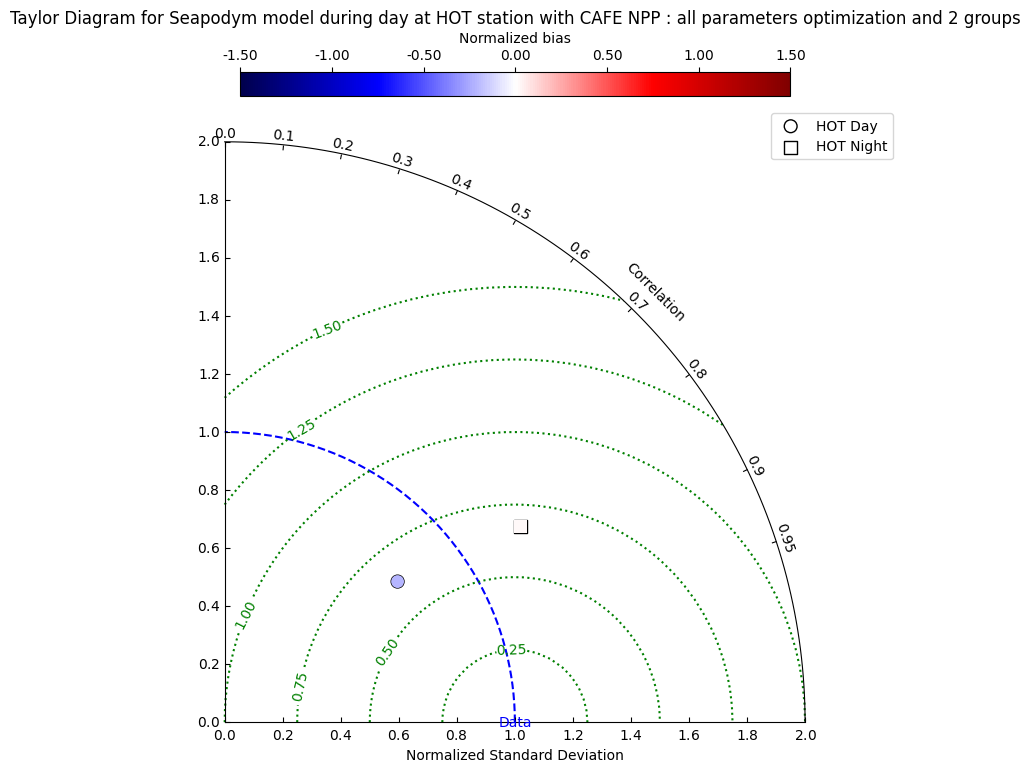

In [31]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred_d1n1, monthly_pred_d1n1 + monthly_pred_d2n1]
all_obs = [monthly_obs_day, monthly_obs_night]

all_names = ["HOT Day", "HOT Night"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title(
    "Taylor Diagram for Seapodym model during day at HOT station with CAFE NPP : all parameters optimization and 2 groups"
)

# export the figure
plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [32]:
diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,0.775807,0.768002,-0.212918,0.631018
1,HOT Night,0.834276,1.220642,0.013229,0.673248
